In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('glass.csv', engine='pyarrow')
data['type'] = data['type'].astype('category')

X, Y = data['Al'].to_numpy(), data['RI'].to_numpy()

In [2]:
from scipy import stats as st


def nw_estimator(t: np.ndarray, x: np.ndarray, y: np.ndarray, h: float):
    tt = np.repeat(np.expand_dims(t, axis=1), len(x), axis=1)
    kde_vals = st.norm.pdf((tt - x)/h)
    w: np.ndarray = kde_vals / kde_vals.sum(axis=1, keepdims=True)
    r_hat = w @ y

    return r_hat, kde_vals, w

In [3]:
def j_hat(x: np.ndarray, y: np.ndarray, h: float):
    r_hat, kde_vals, _ = nw_estimator(x, x, y, h)
    kde_sum = kde_vals.sum(axis=1)

    if (st.norm.pdf(0) == kde_sum).any():
        return np.inf

    risk = np.sum( ((Y-r_hat) * 1/(1-st.norm.pdf(0)/kde_sum))**2 )

    return risk

In [4]:
m = 100
h_values = np.array(range(1, m+1))/m
risks = [j_hat(X, Y, h) for h in h_values]

kde_idx = risks.index(min(risks)) + 1
bandwidth = kde_idx/m
print(bandwidth)

0.13


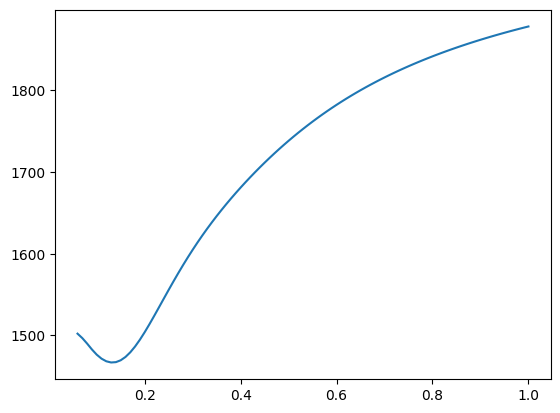

In [5]:
from matplotlib import pyplot as plt

plt.plot(h_values, risks)
plt.show()

In [6]:
def confidence_band(x: np.ndarray, y: np.ndarray, h: float, alpha: float=0.05):
    n = len(x)
    m = (x.max() - x.min())/(3*h)
    q = st.norm.ppf( (1 + (1-alpha)**(1/m)) / 2 )
    
    r_hat, _, w = nw_estimator(np.sort(x), x, y, h)

    sigma2 = 1/(2*(n-1)) * np.sum( (x[1:] - x[:-1])**2 )
    se = np.sqrt(sigma2 * np.sum( w**2 ))

    l_x = r_hat - q*se
    u_x = r_hat + q*se

    return r_hat, l_x, u_x

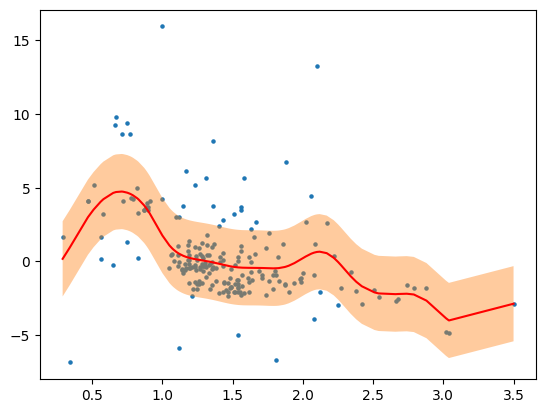

In [7]:
r_hat, l_x, u_x = confidence_band(X, Y, bandwidth)

plt.scatter(X, Y, s=5)
plt.plot(np.sort(X), r_hat, color='r')
plt.fill_between(np.sort(X), l_x, u_x, alpha=0.4)
plt.show()